In [1]:
# Importing Python Libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read the dataset
df = pd.read_csv('../Data/Data_cleaned')
df.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y_no,y_yes
0,1.712900,0.482038,-1.309555,0.033408,-0.614612,-0.371844,-0.344067,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.339795,-0.543393,-1.309555,-0.416710,-0.614612,-0.371844,-0.344067,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.739073,-0.556490,-1.309555,-0.723609,-0.614612,-0.371844,-0.344067,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,-0.542916,-0.445410,-1.309555,-0.465814,-0.614612,-0.371844,-0.344067,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,-1.229468,-0.340635,-1.309555,-0.146639,-0.614612,-0.371844,-0.344067,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [56]:
#Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X=df.drop(columns=['y_yes','y_no'])
y=df['y_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape

(32948, 43)

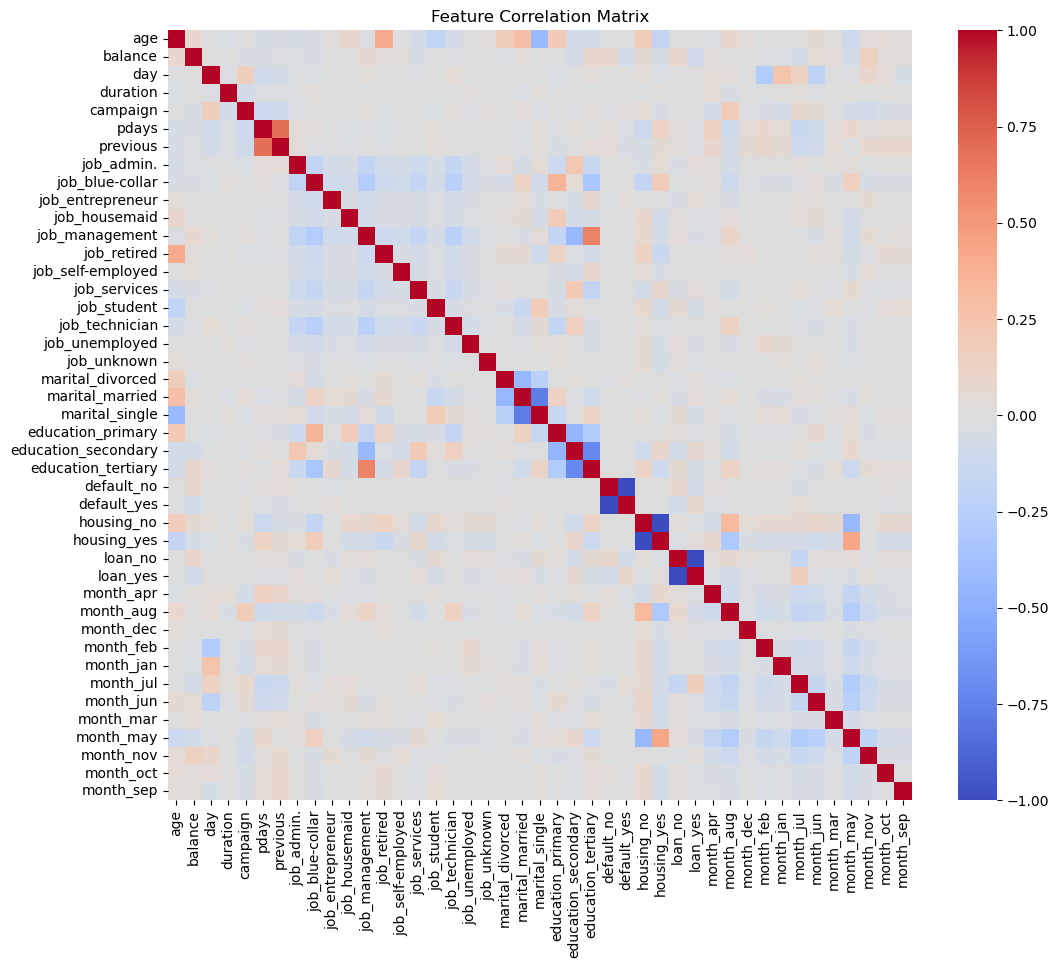

In [57]:
# Calculate correlation matrix
columns=X_train.columns
corr_matrix = pd.DataFrame(X_train, columns=columns).corr()

# Plot a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

In [58]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Train logistic regression with L1 regularization
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=0.1)
model.fit(X_train, y_train)

# Get coefficients
coefficients = model.coef_[0]

# Identify important features
important_features = [columns[i] for i in range(len(coefficients)) if np.abs(coefficients[i]) > 0]
print("Important Features:", important_features)


Important Features: ['balance', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_retired', 'job_self-employed', 'job_student', 'job_technician', 'marital_divorced', 'marital_married', 'education_primary', 'education_secondary', 'housing_yes', 'loan_yes', 'month_apr', 'month_aug', 'month_dec', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep']


In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_neighbors=5)
knn

KNeighborsClassifier()

Justify downsampling

In [61]:
from sklearn.utils import resample, shuffle


# Check class distribution
print(y_train.value_counts())

# Separate the majority and minority classes
X_train_0 = X_train[y_train == 0]  # Features for class 0
X_train_1 = X_train[y_train == 1]  # Features for class 1

# Downsample the majority class (class 0 in this case)
X_train_0_downsampled = resample(
    X_train_0,
    replace=False,                       # Sample without replacement
    n_samples=len(X_train_1),            # Match minority class count
    random_state=42                      # Ensure reproducibility
)

# Combine the downsampled majority class with the minority class
X_train_downsample = pd.concat([X_train_0_downsampled, X_train_1], axis=0)

# Create corresponding target labels
y_train_0_downsampled = pd.Series(0, index=X_train_0_downsampled.index)  # Label 0
y_train_1 = pd.Series(1, index=X_train_1.index)                         # Label 1

# Combine the downsampled labels
y_train_downsample = pd.concat([y_train_0_downsampled, y_train_1], axis=0)

# Shuffle the downsampled dataset to avoid ordering bias
X_train_downsample, y_train_downsample = shuffle(X_train_downsample, y_train_downsample, random_state=42)

print(f'X_train shape : {X_train_downsample.shape} | y_train shape : {X_train_downsample.shape}')


y_yes
0    29407
1     3541
Name: count, dtype: int64
X_train shape : (7082, 43) | y_train shape : (7082, 43)


In [62]:
# Define the parameter grid
parameter_grid = {
    "n_neighbors": range(1, 100, 5),
}

# Perform grid search
grid_search = GridSearchCV(estimator=knn, param_grid=parameter_grid, cv=5)
grid_search.fit(X_train_downsample[important_features],y_train_downsample)
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=11)

In [65]:
# Print the best parameters and the corresponding accuracy
best_model=grid_search.best_estimator_
best_model.fit(X_train_downsample[important_features], y_train_downsample)
y_train_predict=best_model.predict(X_train_downsample[important_features])
y_test_predict=best_model.predict(X_test[important_features])

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score
print("Training Accuracy:", accuracy_score(y_train_downsample, y_train_predict))
print("Confusion Matrix:\n", confusion_matrix(y_train_downsample, y_train_predict))
print("Classification Report:\n", classification_report(y_train_downsample, y_train_predict))

Training Accuracy: 0.8417113809658289
Confusion Matrix:
 [[2970  571]
 [ 550 2991]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      3541
           1       0.84      0.84      0.84      3541

    accuracy                           0.84      7082
   macro avg       0.84      0.84      0.84      7082
weighted avg       0.84      0.84      0.84      7082



In [67]:
print(classification_report(y_test, y_test_predict))


              precision    recall  f1-score   support

           0       0.97      0.82      0.89      7353
           1       0.35      0.81      0.49       885

    accuracy                           0.82      8238
   macro avg       0.66      0.81      0.69      8238
weighted avg       0.91      0.82      0.85      8238



In [68]:
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='binary')
recall = recall_score(y_test, y_test_predict, average='binary')
f1 = f1_score(y_test, y_test_predict, average='binary')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy: 0.82
Precision: 0.35
Recall: 0.81
F1-Score: 0.49
